In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from sklearn.model_selection import KFold
from pathlib import Path
from PIL import Image
from collections import defaultdict
from torchvision.models import resnet18, ResNet18_Weights
from umap.umap_ import UMAP
import os
import seaborn as sns
from tqdm import tqdm
import time
from torchvision.transforms import v2

In [2]:
class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)
        
        # Store tumor type in self.labels (0 = non-recurrent, 1 = recurrent)
        for img in self.image_files:
            if "positive" in img:
                self.labels.append(1)
            elif "negative" in img:
                self.labels.append(0)
               
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        label = self.labels[idx]  # Get the corresponding label
        
        if self.transform:
            image = self.transform(image)
            
        return image, label  # Return both image and label


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize to 224x224 (if not already)
    transforms.ToTensor(), # convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/einstein_patches/'
dataset = SingleChannelDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

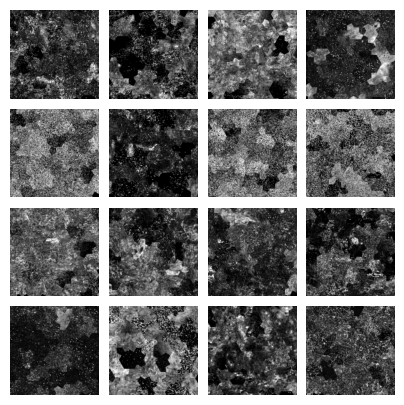

In [4]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [5]:
def train(model, train_loader, criterion, optimizer, device):
    model = model.to(device)
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs).logits  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device):
    model = model.to(device)
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch 1/5


100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Train Loss: 1.7896, Train Accuracy: 0.5193


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Test Loss: 0.5375, Test Accuracy: 0.6974
Epoch 2/5


100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.3261, Train Accuracy: 0.8676


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


Test Loss: 0.3059, Test Accuracy: 0.8676
Epoch 3/5


100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Train Loss: 0.1411, Train Accuracy: 0.9519


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


Test Loss: 0.1646, Test Accuracy: 0.9338
Epoch 4/5


100%|██████████| 40/40 [00:22<00:00,  1.82it/s]


Train Loss: 0.0521, Train Accuracy: 0.9858


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Test Loss: 0.1059, Test Accuracy: 0.9527
Epoch 5/5


100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


Train Loss: 0.0153, Train Accuracy: 0.9992


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  3.07it/s]


Test Loss: 0.0863, Test Accuracy: 0.9645


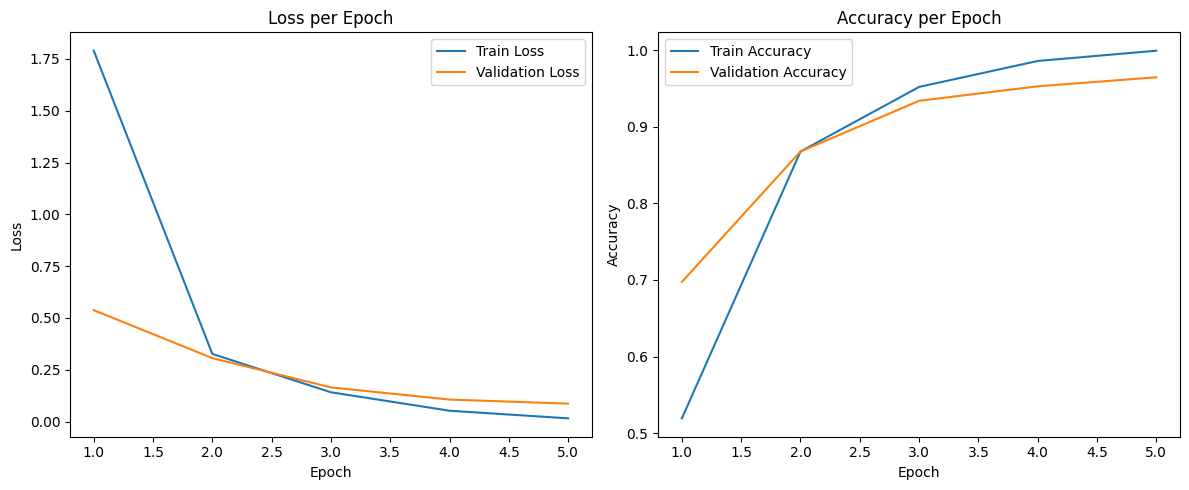

Epoch 1/5


100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.2246, Train Accuracy: 0.9236


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]


Test Loss: 0.0521, Test Accuracy: 0.9929
Epoch 2/5


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.0235, Train Accuracy: 0.9953


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Test Loss: 0.0167, Test Accuracy: 1.0000
Epoch 3/5


100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


Train Loss: 0.0086, Train Accuracy: 1.0000


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


Test Loss: 0.0063, Test Accuracy: 1.0000
Epoch 4/5


100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


Train Loss: 0.0035, Train Accuracy: 1.0000


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


Test Loss: 0.0046, Test Accuracy: 1.0000
Epoch 5/5


100%|██████████| 40/40 [00:23<00:00,  1.72it/s]


Train Loss: 0.0022, Train Accuracy: 1.0000


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Test Loss: 0.0040, Test Accuracy: 1.0000


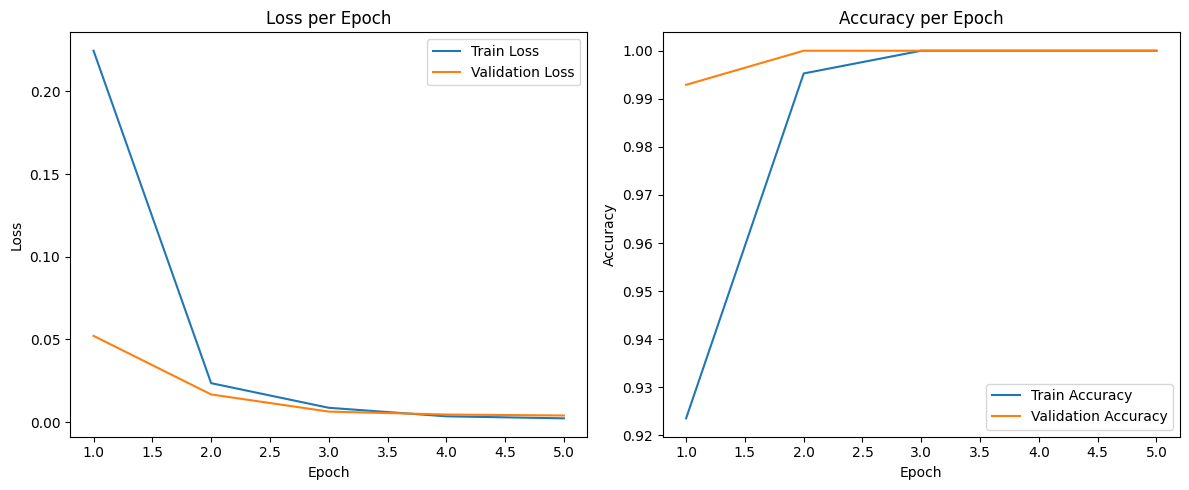

Epoch 1/5


100%|██████████| 40/40 [00:23<00:00,  1.70it/s]


Train Loss: 0.0318, Train Accuracy: 0.9937


Evaluating: 100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


Test Loss: 0.0231, Test Accuracy: 0.9905
Epoch 2/5


100%|██████████| 40/40 [00:23<00:00,  1.70it/s]


Train Loss: 0.0073, Train Accuracy: 0.9976


Evaluating: 100%|██████████| 14/14 [00:40<00:00,  2.91s/it]


Test Loss: 0.0012, Test Accuracy: 1.0000
Epoch 3/5


100%|██████████| 40/40 [00:48<00:00,  1.21s/it]


Train Loss: 0.0042, Train Accuracy: 0.9984


Evaluating: 100%|██████████| 14/14 [00:53<00:00,  3.84s/it]


Test Loss: 0.0013, Test Accuracy: 1.0000
Epoch 4/5


100%|██████████| 40/40 [01:33<00:00,  2.33s/it]


Train Loss: 0.0018, Train Accuracy: 1.0000


Evaluating: 100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


Test Loss: 0.0008, Test Accuracy: 1.0000
Epoch 5/5


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


Train Loss: 0.0002, Train Accuracy: 1.0000


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


Test Loss: 0.0005, Test Accuracy: 1.0000


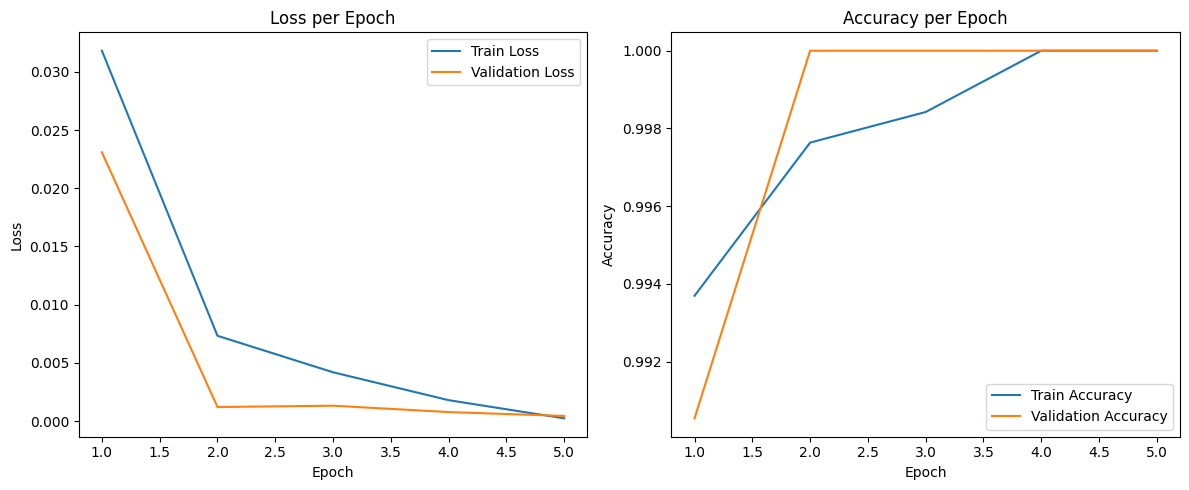

Epoch 1/5


100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


Train Loss: 0.0493, Train Accuracy: 0.9858


Evaluating: 100%|██████████| 14/14 [00:06<00:00,  2.07it/s]


Test Loss: 0.0130, Test Accuracy: 0.9953
Epoch 2/5


100%|██████████| 40/40 [01:48<00:00,  2.72s/it]


Train Loss: 0.0095, Train Accuracy: 0.9945


Evaluating: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Test Loss: 0.0008, Test Accuracy: 1.0000
Epoch 3/5


100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Train Loss: 0.0017, Train Accuracy: 1.0000


Evaluating: 100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Test Loss: 0.0004, Test Accuracy: 1.0000
Epoch 4/5


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


Train Loss: 0.0003, Train Accuracy: 1.0000


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]


Test Loss: 0.0002, Test Accuracy: 1.0000
Epoch 5/5


100%|██████████| 40/40 [01:57<00:00,  2.94s/it]


Train Loss: 0.0002, Train Accuracy: 1.0000


Evaluating: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


Test Loss: 0.0002, Test Accuracy: 1.0000


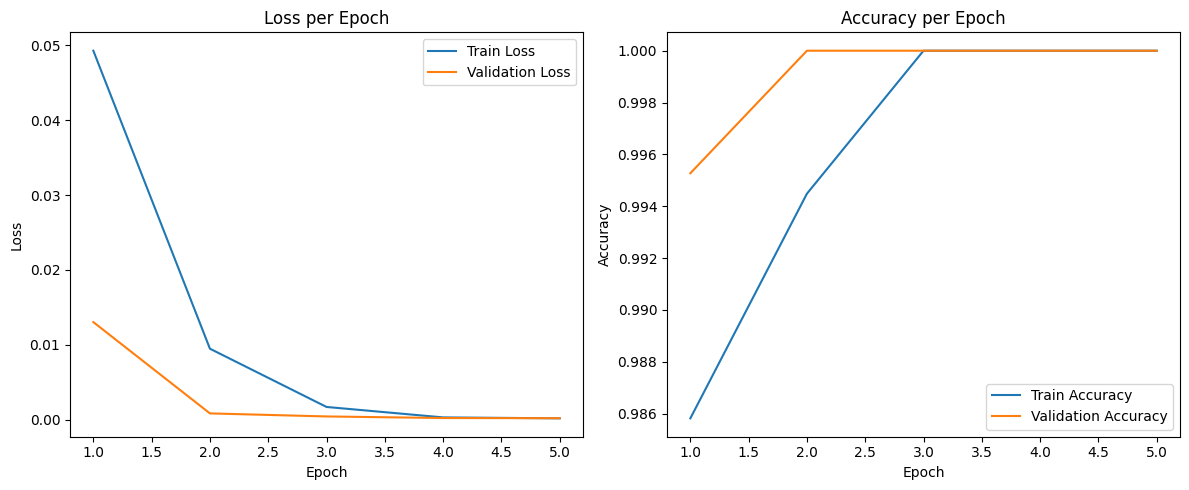

In [6]:
from transformers import ConvNextForImageClassification

model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")
# use 4-fold cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

splits = list(kf.split(range(len(dataset))))
for split in splits:
    train_idx, test_idx = split
    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)
    # define DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



    num_epochs = 5
    device = "cuda"

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        scheduler.step()
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    # plotting training and validation loss and accuracy
    epochs = range(1, num_epochs + 1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    ax[0].plot(epochs, train_losses, label='Train Loss')
    ax[0].plot(epochs, val_losses, label='Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss per Epoch')
    ax[0].legend()

    # Accuracy plot
    ax[1].plot(epochs, train_accuracies, label='Train Accuracy')
    ax[1].plot(epochs, val_accuracies, label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy per Epoch')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


In [7]:
class MultiChannelDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.patch_dict = defaultdict(list)
        self.labels = []
        self.samples = []
        
        # populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            if not os.path.isdir(full_path):
                continue
                
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            full_image_path.sort()
           
            for img_path in full_image_path:
                img_array = self._load_image_as_tensor(img_path)
                # use the index of the patch along with its category (positive/negative) as key for the dictionary
                sample_key = os.path.basename(img_path)[-5]
                if "positive" in img_path:
                    sample_key = "positive" + "_" + sample_key
                else:
                    sample_key = "negative" + "_" + sample_key
                self.patch_dict[sample_key].append(img_array)
                
        # convert the dictionary into list so we can get the samples by indexing
        for patch in self.patch_dict:
            self.samples.append([]) # create a new list for each "sample"
            self.samples[-1].extend(self.patch_dict[patch]) # add the patch to the list
            if "positive" in patch:
                self.labels.append(1)
            elif "negative" in patch:
                self.labels.append(0)
       
    def _load_image_as_tensor(self, path):
        """
        Load an image as a tensor.
       
        Args:
            path (str): Path to image file
           
        Returns:
            torch.Tensor: Image as tensor with shape [1, H, W]
        """
        # open image using PIL
        with Image.open(path) as img:
            # convert to grayscale if not already
            if img.mode != 'L':
                img = img.convert('L')
            # convert to NumPy array
            img_np = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
            img_tensor = torch.from_numpy(img_np).unsqueeze(0)
            # transform the tensor if needed
            if self.transform:
                img_tensor = self.transform(img_tensor)
        return img_tensor
    
    def __len__(self):
        return len(self.samples)
       
    def __getitem__(self, idx):
        patch = self.samples[idx]
        label = self.labels[idx]
       
        # stack list of images for each tissue to form a multi-channel tensor
        sample_tensor = torch.stack(patch, dim=0)  # Shape: [num_channels, 1, H, W]
        sample_tensor = sample_tensor.squeeze(1)  # Remove the color channel, shape: [num_channels, H, W]
        
        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)
           
        return sample_tensor, label

In [ ]:
class MultiChannelResnet(nn.Module):
    def __init__(self, num_channels=50, num_classes=2, dropout_p=0.5):
        """
        Modified ResNet model to handle multi-channel inputs beyond 3 channels, with added dropout for regularization.
        
        Args:
            num_channels (int): Number of input channels (default: 50)
            num_classes (int): Number of output classes (default: 2)
            dropout_p (float): Dropout probability (default: 0.5)
        """
        super(MultiChannelResnet, self).__init__()
        
        # load a pretrained ResNet model
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # replace the first convolutional layer to accept num_channels instead of 3
        original_layer = self.model.conv1
        new_layer = nn.Conv2d(
            num_channels, 
            original_layer.out_channels,
            kernel_size=original_layer.kernel_size,
            stride=original_layer.stride,
            padding=original_layer.padding,
            bias=(original_layer.bias is not None)
        )
        
        # initialize the new layer with scaled weights from pretrained model
        with torch.no_grad():
            # scale the weights to maintain activation magnitude
            scale_factor = 3 / num_channels  # 3 is original RGB channels
            # only use the first 3 channels for initialization if using pretrained weights
            if num_channels > 3:
                new_layer.weight[:, :3, :, :] = original_layer.weight * scale_factor
                # initialize remaining channels with small random values
                nn.init.kaiming_normal_(new_layer.weight[:, 3:, :, :], mode='fan_out')
            else:
                new_layer.weight = torch.nn.Parameter(original_layer.weight[:, :num_channels, :, :] * scale_factor)
        
        # replace the layer
        self.model.conv1 = new_layer
        
        # Add dropout layer after the average pooling and before the final fully connected layer
        self.dropout = nn.Dropout(p=dropout_p)
        
        # modify the final fully connected layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network with dropout for regularization.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_channels, height, width]
        
        Returns:
            torch.Tensor: Output predictions of shape [batch_size, num_classes]
        """
        # orward through all layers except the final FC
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # apply dropout before the final FC
        x = self.model.fc(x)
        return x


In [ ]:
def train_model_with_visualization(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    
    # lists to store metrics for visualization
    train_losses = []
    val_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        # training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        # Store training metrics
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        
        # Testing phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        # calculate testing metrics
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = correct / total
        
        # store validation metrics
        val_losses.append(test_loss)
        test_accs.append(test_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {test_loss:.4f}, Val Acc: {test_accuracy:.4f}')
    print(train_accs)
    print(test_accs)
    
    return train_losses, val_losses, train_accs, test_accs

def plot_metrics(train_losses, val_losses, train_accs, val_accs, epochs):
    """
    Plot training and validation metrics.
    
    Args:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        train_accs: List of training accuracies per epoch
        test_accs: List of validation accuracies per epoch
        epochs: Number of training epochs
    """
    epochs_range = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()


## Training Multi-channel Resnet Model

In [15]:
from itertools import product
multi_channel_dataset = MultiChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches/', transform=None)

# use 3-fold cross-validation because there are 18 samples in the dataset
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_indices = list(kf.split(range(len(multi_channel_dataset))))

# hyperparameter grid
param_grid = {
    'lr': [0.001, 0.0005, 0.0001],
    'weight_decay': [1e-4, 1e-5, 0],
    'optimizer': ['adam', 'sgd']
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fold_results = []
all_hyperparam_results = {}

for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n=== Fold {fold+1} ===")
    mc_train_dataset = Subset(multi_channel_dataset, train_idx)
    mc_test_dataset = Subset(multi_channel_dataset, test_idx)

    sc_train_loader = DataLoader(
        mc_train_dataset, 
        batch_size=4, 
        shuffle=True, 
        num_workers=4
    )

    mc_test_loader = DataLoader(
        mc_test_dataset, 
        batch_size=4, 
        shuffle=False, 
        num_workers=4
    )

    best_val_acc = 0
    best_params = None
    best_train_losses, best_test_losses, best_train_accs, best_val_accs = None, None, None, None

    for lr, weight_decay, opt_name in product(param_grid['lr'], param_grid['weight_decay'], param_grid['optimizer']):
        # re-initialize model and optimizer for each run
        model = MultiChannelResnet(num_channels=94, num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt_name == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
        else:
            raise ValueError(f"Unknown optimizer: {opt_name}")

        train_losses, test_losses, train_accs, val_accs = train_model_with_visualization(
            model, criterion, optimizer, sc_train_loader, mc_test_loader
        )
        max_val_acc = max(val_accs)
        print(f"Fold {fold+1} Grid search: optimizer={opt_name}, lr={lr}, weight_decay={weight_decay}, max_val_acc={max_val_acc:.4f}")
        # Store results for this hyperparameter combination and fold
        hyperparam_key = (opt_name, lr, weight_decay)
        if hyperparam_key not in all_hyperparam_results:
            all_hyperparam_results[hyperparam_key] = []
        all_hyperparam_results[hyperparam_key].append(max_val_acc)
        if max_val_acc > best_val_acc:
            best_val_acc = max_val_acc
            best_params = {'optimizer': opt_name, 'lr': lr, 'weight_decay': weight_decay}
            best_train_losses, best_test_losses, best_train_accs, best_val_accs = train_losses, test_losses, train_accs, val_accs

    fold_results.append({
        'fold': fold+1,
        'best_params': best_params,
        'best_val_acc': best_val_acc,
        'train_losses': best_train_losses,
        'test_losses': best_test_losses,
        'train_accs': best_train_accs,
        'val_accs': best_val_accs
    })

# After all folds, compute and report the average validation accuracy for each hyperparameter combination
avg_val_acc_per_hyperparam = {
    k: sum(v)/len(v) for k, v in all_hyperparam_results.items()
}

# print average validation accuracy for each hyperparameter combination
print("\nAverage validation accuracy for each hyperparameter combination across all folds:")
for hyperparam, avg_acc in avg_val_acc_per_hyperparam.items():
    print(f"  optimizer={hyperparam[0]}, lr={hyperparam[1]}, weight_decay={hyperparam[2]}: avg_val_acc={avg_acc:.4f}")

# find the best hyperparameter combination by average validation accuracy
best_hyperparam, best_avg_val_acc = max(avg_val_acc_per_hyperparam.items(), key=lambda x: x[1])
print(f"\nBest hyperparameters across all folds: optimizer={best_hyperparam[0]}, lr={best_hyperparam[1]}, weight_decay={best_hyperparam[2]}, average validation accuracy: {best_avg_val_acc:.4f}")

avg_val_acc = sum([fr['best_val_acc'] for fr in fold_results]) / len(fold_results)
print(f"\nAverage best validation accuracy across folds: {avg_val_acc:.4f}")



=== Fold 1 ===
Epoch 1/20, Train Loss: 1.4924, Train Acc: 0.7500, Val Loss: 0.5451, Val Acc: 1.0000
Epoch 2/20, Train Loss: 1.3510, Train Acc: 0.9167, Val Loss: 18.8596, Val Acc: 0.8333
Epoch 3/20, Train Loss: 2.8701, Train Acc: 0.6667, Val Loss: 5.2863, Val Acc: 0.1667
Epoch 4/20, Train Loss: 3.3997, Train Acc: 0.8333, Val Loss: 2.9384, Val Acc: 0.3333
Epoch 5/20, Train Loss: 0.5593, Train Acc: 0.9167, Val Loss: 0.0060, Val Acc: 1.0000
Epoch 6/20, Train Loss: 0.1600, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 7/20, Train Loss: 0.0496, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 8/20, Train Loss: 1.1569, Train Acc: 0.9167, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 9/20, Train Loss: 0.0689, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 10/20, Train Loss: 1.4816, Train Acc: 0.8333, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 11/20, Train Loss: 0.4441, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 12/20, Train Loss: 0.4402, Train Acc: 0.


--- Fold 1 ---
Epoch 1/20, Train Loss: 1.1356, Train Acc: 0.8333, Val Loss: 0.5380, Val Acc: 0.8333
Epoch 2/20, Train Loss: 2.4221, Train Acc: 0.8333, Val Loss: 15.9131, Val Acc: 0.1667
Epoch 3/20, Train Loss: 2.4557, Train Acc: 0.7500, Val Loss: 162.7303, Val Acc: 0.1667
Epoch 4/20, Train Loss: 0.3706, Train Acc: 0.9167, Val Loss: 271.1409, Val Acc: 0.1667
Epoch 5/20, Train Loss: 0.0063, Train Acc: 1.0000, Val Loss: 111.5622, Val Acc: 0.1667
Epoch 6/20, Train Loss: 0.0031, Train Acc: 1.0000, Val Loss: 26.8978, Val Acc: 0.5000
Epoch 7/20, Train Loss: 0.3011, Train Acc: 0.9167, Val Loss: 11.0657, Val Acc: 0.5000
Epoch 8/20, Train Loss: 0.0106, Train Acc: 1.0000, Val Loss: 7.7470, Val Acc: 0.5000
Epoch 9/20, Train Loss: 0.7976, Train Acc: 0.9167, Val Loss: 7.5083, Val Acc: 0.5000
Epoch 10/20, Train Loss: 0.5005, Train Acc: 0.9167, Val Loss: 1.5977, Val Acc: 0.6667
Epoch 11/20, Train Loss: 0.1290, Train Acc: 1.0000, Val Loss: 0.4597, Val Acc: 0.8333
Epoch 12/20, Train Loss: 0.0410, Train

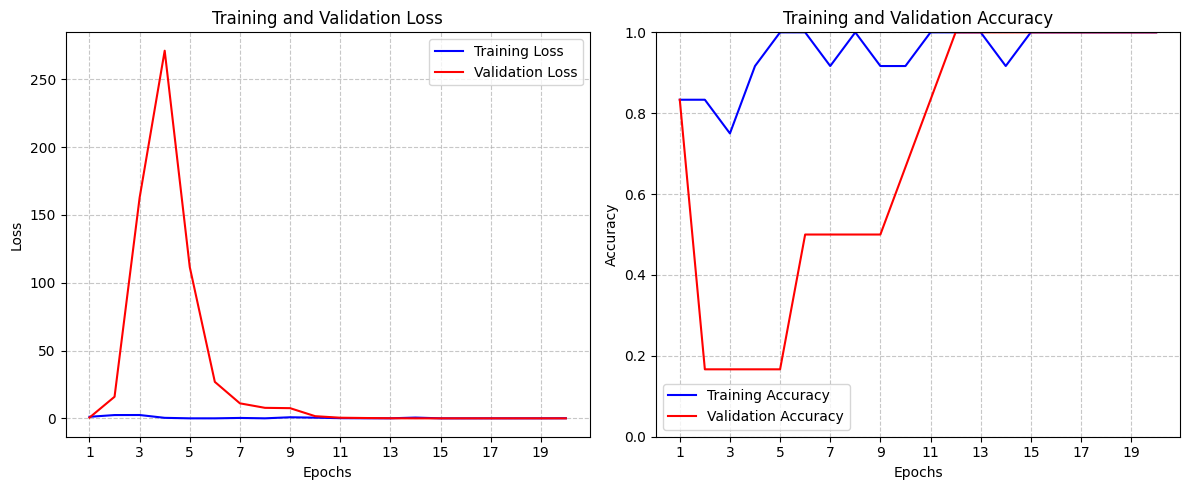


--- Fold 2 ---
Epoch 1/20, Train Loss: 1.9741, Train Acc: 0.5833, Val Loss: 9.3198, Val Acc: 0.1667
Epoch 2/20, Train Loss: 4.2644, Train Acc: 0.6667, Val Loss: 0.8613, Val Acc: 0.8333
Epoch 3/20, Train Loss: 4.8724, Train Acc: 0.6667, Val Loss: 1.1499, Val Acc: 0.8333
Epoch 4/20, Train Loss: 2.0658, Train Acc: 0.6667, Val Loss: 5.9487, Val Acc: 0.1667
Epoch 5/20, Train Loss: 0.8859, Train Acc: 0.8333, Val Loss: 2.1225, Val Acc: 0.5000
Epoch 6/20, Train Loss: 0.1588, Train Acc: 1.0000, Val Loss: 0.5862, Val Acc: 0.8333
Epoch 7/20, Train Loss: 0.1057, Train Acc: 1.0000, Val Loss: 0.1315, Val Acc: 1.0000
Epoch 8/20, Train Loss: 0.1021, Train Acc: 1.0000, Val Loss: 0.0526, Val Acc: 1.0000
Epoch 9/20, Train Loss: 0.5915, Train Acc: 0.9167, Val Loss: 0.0319, Val Acc: 1.0000
Epoch 10/20, Train Loss: 0.0468, Train Acc: 1.0000, Val Loss: 0.0181, Val Acc: 1.0000
Epoch 11/20, Train Loss: 0.0432, Train Acc: 1.0000, Val Loss: 0.0143, Val Acc: 1.0000
Epoch 12/20, Train Loss: 0.6135, Train Acc: 0.9

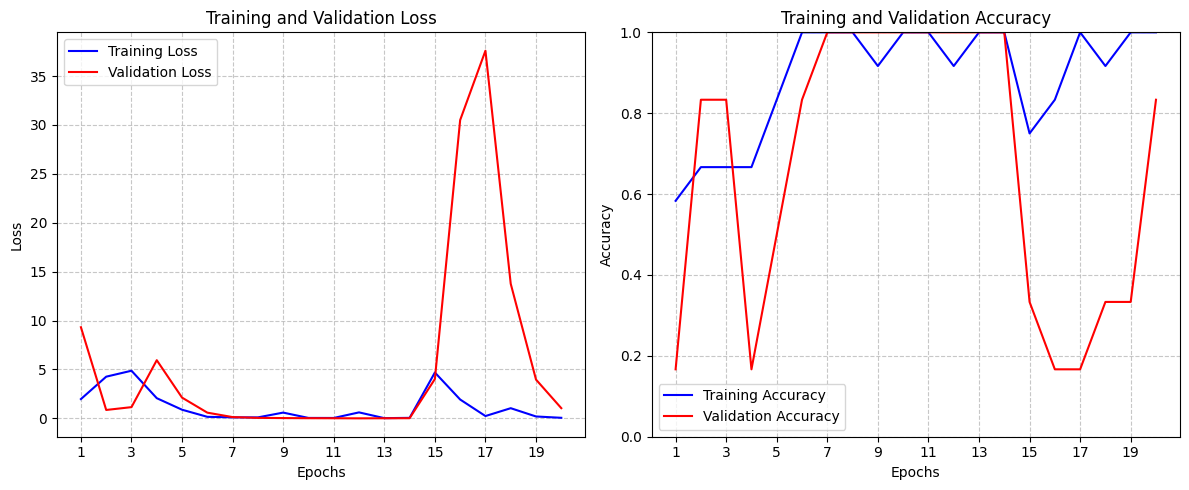


--- Fold 3 ---
Epoch 1/20, Train Loss: 1.5545, Train Acc: 0.6667, Val Loss: 11.7632, Val Acc: 0.5000
Epoch 2/20, Train Loss: 2.1787, Train Acc: 0.8333, Val Loss: 7.4246, Val Acc: 0.5000
Epoch 3/20, Train Loss: 2.0967, Train Acc: 0.8333, Val Loss: 6.4504, Val Acc: 0.5000
Epoch 4/20, Train Loss: 5.5113, Train Acc: 0.6667, Val Loss: 5.1769, Val Acc: 0.5000
Epoch 5/20, Train Loss: 3.0776, Train Acc: 0.7500, Val Loss: 1.5420, Val Acc: 0.5000
Epoch 6/20, Train Loss: 0.6337, Train Acc: 0.9167, Val Loss: 1.0279, Val Acc: 0.8333
Epoch 7/20, Train Loss: 0.2015, Train Acc: 1.0000, Val Loss: 0.9815, Val Acc: 0.8333
Epoch 8/20, Train Loss: 2.7892, Train Acc: 0.6667, Val Loss: 1.8066, Val Acc: 0.6667
Epoch 9/20, Train Loss: 1.9464, Train Acc: 0.8333, Val Loss: 2.7675, Val Acc: 0.5000
Epoch 10/20, Train Loss: 0.7959, Train Acc: 0.8333, Val Loss: 1.9353, Val Acc: 0.5000
Epoch 11/20, Train Loss: 1.5261, Train Acc: 0.7500, Val Loss: 1.9841, Val Acc: 0.8333
Epoch 12/20, Train Loss: 0.4255, Train Acc: 0.

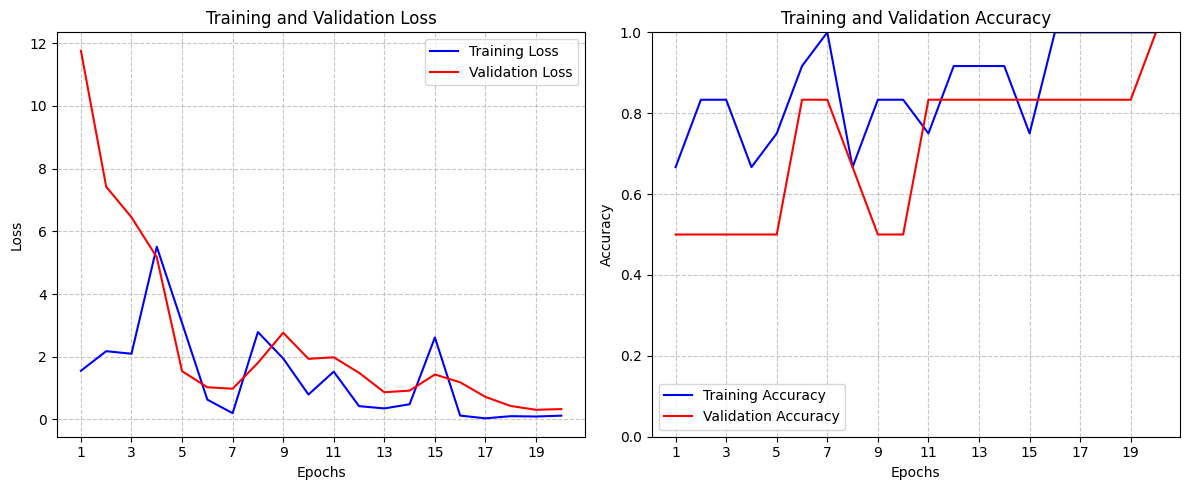


Average best validation accuracy across folds (rerun): 1.0000


In [ ]:


# rerun training with the best hyperparameters
rerun_fold_results = []

for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n--- Fold {fold+1} ---")
    mc_train_dataset = Subset(multi_channel_dataset, train_idx)
    mc_test_dataset = Subset(multi_channel_dataset, test_idx)

    mc_train_loader = DataLoader(
        mc_train_dataset, 
        batch_size=4, 
        shuffle=True, 
        num_workers=4
    )

    mc_test_loader = DataLoader(
        mc_test_dataset, 
        batch_size=4, 
        shuffle=False,
        num_workers=4
    )

    # Initialize model, criterion, optimizer
    model = MultiChannelResnet(num_channels=94, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


    # Train and get metrics
    train_losses, val_losses, train_accs, val_accs = train_model_with_visualization(
        model, criterion, optimizer, mc_train_loader, mc_test_loader
    )

    # Store results
    rerun_fold_results.append({
        'fold': fold+1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })

    # Plot metrics for this fold
    plot_metrics(train_losses, val_losses, train_accs, val_accs, epochs=20)

# Optionally, print summary statistics
avg_rerun_val_acc = sum([max(fr['val_accs']) for fr in rerun_fold_results]) / len(rerun_fold_results)
print(f"\nAverage best validation accuracy across folds (rerun): {avg_rerun_val_acc:.4f}")


In [21]:
# transform images to greyscale and to tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

single_channel_dataset = SingleChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches/', transform=transform)

# use 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_indices = list(kf.split(range(len(single_channel_dataset))))

# hyperparameter grid
param_grid = {
    'lr': [0.001, 0.0005, 0.0001],
    'weight_decay': [1e-4, 1e-5, 0],
    'optimizer': ['adam', 'sgd']
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# store results for each fold and all hyperparameter combinations
fold_results = []
all_hyperparam_results = {}

for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n=== Fold {fold+1} ===")
    sc_train_dataset = Subset(single_channel_dataset, train_idx)
    sc_test_dataset = Subset(single_channel_dataset, test_idx)

    sc_train_loader = DataLoader(
        sc_train_dataset, 
        batch_size=4, 
        shuffle=True, 
        num_workers=4
    )

    sc_test_loader = DataLoader(
        sc_test_dataset, 
        batch_size=4, 
        shuffle=False, 
        num_workers=4
    )

    best_val_acc = 0
    best_params = None
    best_train_losses, best_test_losses, best_train_accs, best_val_accs = None, None, None, None

    for lr, weight_decay, opt_name in product(param_grid['lr'], param_grid['weight_decay'], param_grid['optimizer']):
        # re-initialize model and optimizer for each run
        model = MultiChannelResnet(num_channels=1, num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt_name == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
        else:
            raise ValueError(f"Unknown optimizer: {opt_name}")

        train_losses, test_losses, train_accs, val_accs = train_model_with_visualization(
            model, criterion, optimizer, sc_train_loader, sc_test_loader
        )
        max_val_acc = max(val_accs)
        print(f"Fold {fold+1} Grid search: optimizer={opt_name}, lr={lr}, weight_decay={weight_decay}, max_val_acc={max_val_acc:.4f}")
        # Store results for this hyperparameter combination and fold
        hyperparam_key = (opt_name, lr, weight_decay)
        if hyperparam_key not in all_hyperparam_results:
            all_hyperparam_results[hyperparam_key] = []
        all_hyperparam_results[hyperparam_key].append(max_val_acc)
        if max_val_acc > best_val_acc:
            best_val_acc = max_val_acc
            best_params = {'optimizer': opt_name, 'lr': lr, 'weight_decay': weight_decay}
            best_train_losses, best_test_losses, best_train_accs, best_val_accs = train_losses, test_losses, train_accs, val_accs
        
    fold_results.append({
        'fold': fold+1,
        'best_params': best_params,
        'best_val_acc': best_val_acc,
        'train_losses': best_train_losses,
        'test_losses': best_test_losses,
        'train_accs': best_train_accs,
        'val_accs': best_val_accs
    })

# after training, report the hyperparameters with the best average validation accuracy
avg_val_acc_per_hyperparam = {
    k: sum(v)/len(v) for k, v in all_hyperparam_results.items()
}
best_hyperparam, best_avg_val_acc = max(avg_val_acc_per_hyperparam.items(), key=lambda x: x[1])
print(f"\nBest hyperparameters across all folds: optimizer={best_hyperparam[0]}, lr={best_hyperparam[1]}, weight_decay={best_hyperparam[2]}, average validation accuracy: {best_avg_val_acc:.4f}")

avg_val_acc = sum([fr['best_val_acc'] for fr in fold_results]) / len(fold_results)
print(f"\nAverage best validation accuracy across folds: {avg_val_acc:.4f}")


=== Fold 1 ===
Epoch 1/20, Train Loss: 181.9302, Train Acc: 0.6986, Val Loss: 49.1272, Val Acc: 0.8546
Epoch 2/20, Train Loss: 100.2435, Train Acc: 0.8520, Val Loss: 28.8930, Val Acc: 0.9238
Epoch 3/20, Train Loss: 82.3744, Train Acc: 0.8936, Val Loss: 59.6754, Val Acc: 0.7801
Epoch 4/20, Train Loss: 71.3325, Train Acc: 0.9087, Val Loss: 8.7191, Val Acc: 0.9787
Epoch 5/20, Train Loss: 38.2319, Train Acc: 0.9504, Val Loss: 5.4693, Val Acc: 0.9894
Epoch 6/20, Train Loss: 22.9106, Train Acc: 0.9761, Val Loss: 18.8914, Val Acc: 0.9379
Epoch 7/20, Train Loss: 11.8777, Train Acc: 0.9849, Val Loss: 6.5595, Val Acc: 0.9858
Epoch 8/20, Train Loss: 21.2921, Train Acc: 0.9743, Val Loss: 11.8601, Val Acc: 0.9663
Epoch 9/20, Train Loss: 10.5551, Train Acc: 0.9894, Val Loss: 36.1896, Val Acc: 0.8865
Epoch 10/20, Train Loss: 18.7388, Train Acc: 0.9770, Val Loss: 5.0791, Val Acc: 0.9876
Epoch 11/20, Train Loss: 6.2130, Train Acc: 0.9920, Val Loss: 8.2879, Val Acc: 0.9823
Epoch 12/20, Train Loss: 12.3

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/root/anaconda3/envs/mass_spec_img/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/root/anaconda3/envs/mass_spec_img/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/root/anaconda3/envs/mass_spec_img/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/envs/mass_spec_img/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/root/anaconda3/envs/mass_spec_img/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwa

Epoch 1/20, Train Loss: 176.8962, Train Acc: 0.7181, Val Loss: 61.2565, Val Acc: 0.8227
Epoch 2/20, Train Loss: 125.4430, Train Acc: 0.8254, Val Loss: 34.0690, Val Acc: 0.8830
Epoch 3/20, Train Loss: 103.4206, Train Acc: 0.8599, Val Loss: 17.5826, Val Acc: 0.9486
Epoch 4/20, Train Loss: 76.1097, Train Acc: 0.9105, Val Loss: 10.0723, Val Acc: 0.9716
Epoch 5/20, Train Loss: 105.9737, Train Acc: 0.8874, Val Loss: 10.2963, Val Acc: 0.9805
Epoch 6/20, Train Loss: 83.8355, Train Acc: 0.8883, Val Loss: 12.1443, Val Acc: 0.9716
Epoch 7/20, Train Loss: 78.1766, Train Acc: 0.8998, Val Loss: 5.6822, Val Acc: 0.9858
Epoch 8/20, Train Loss: 79.2112, Train Acc: 0.9096, Val Loss: 6.8481, Val Acc: 0.9805
Epoch 9/20, Train Loss: 72.5451, Train Acc: 0.9078, Val Loss: 7.7671, Val Acc: 0.9787
Epoch 10/20, Train Loss: 57.2739, Train Acc: 0.9238, Val Loss: 6.5931, Val Acc: 0.9805
Epoch 11/20, Train Loss: 51.5723, Train Acc: 0.9326, Val Loss: 7.4927, Val Acc: 0.9858
Epoch 12/20, Train Loss: 55.7519, Train Ac


--- Fold 1 ---
Epoch 1/20, Train Loss: 12.1576, Train Acc: 0.8333, Val Loss: 1.9471, Val Acc: 0.9645
Epoch 2/20, Train Loss: 2.3212, Train Acc: 0.9778, Val Loss: 1.5908, Val Acc: 0.9592
Epoch 3/20, Train Loss: 2.3111, Train Acc: 0.9778, Val Loss: 1.8418, Val Acc: 0.9628
Epoch 4/20, Train Loss: 2.8309, Train Acc: 0.9761, Val Loss: 2.0652, Val Acc: 0.9450
Epoch 5/20, Train Loss: 0.9274, Train Acc: 0.9920, Val Loss: 1.0119, Val Acc: 0.9752
Epoch 6/20, Train Loss: 0.4545, Train Acc: 0.9956, Val Loss: 0.7224, Val Acc: 0.9840
Epoch 7/20, Train Loss: 0.3361, Train Acc: 0.9973, Val Loss: 1.0866, Val Acc: 0.9734
Epoch 8/20, Train Loss: 0.3357, Train Acc: 0.9956, Val Loss: 2.4050, Val Acc: 0.9539
Epoch 9/20, Train Loss: 0.6136, Train Acc: 0.9929, Val Loss: 1.6292, Val Acc: 0.9645
Epoch 10/20, Train Loss: 0.2838, Train Acc: 0.9982, Val Loss: 0.9151, Val Acc: 0.9823
Epoch 11/20, Train Loss: 0.4980, Train Acc: 0.9965, Val Loss: 2.6532, Val Acc: 0.9433
Epoch 12/20, Train Loss: 2.8493, Train Acc: 0.

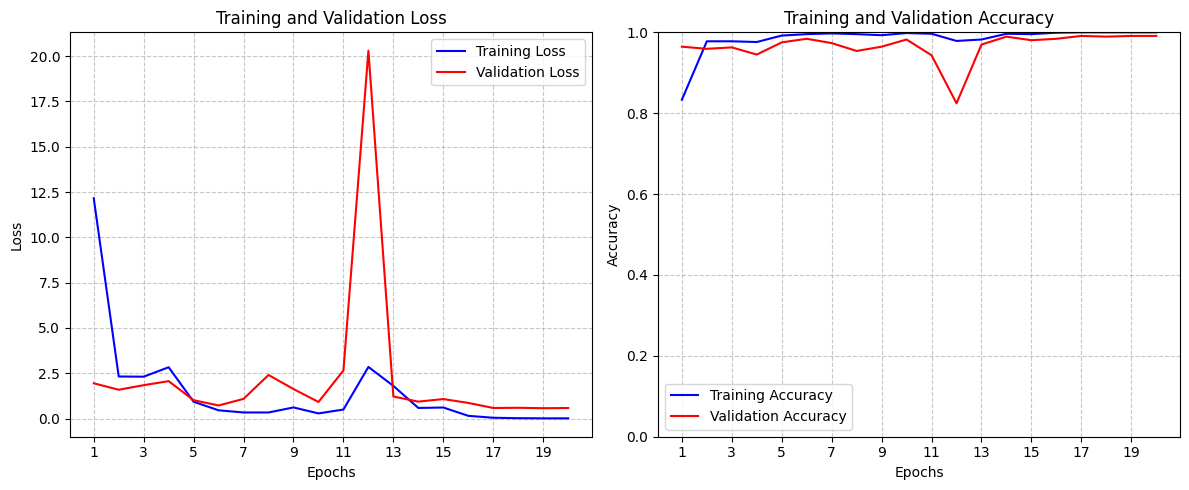


--- Fold 2 ---
Epoch 1/20, Train Loss: 12.6394, Train Acc: 0.8431, Val Loss: 41.3141, Val Acc: 0.5621
Epoch 2/20, Train Loss: 3.6951, Train Acc: 0.9574, Val Loss: 1.6994, Val Acc: 0.9574
Epoch 3/20, Train Loss: 2.1361, Train Acc: 0.9832, Val Loss: 0.9162, Val Acc: 0.9770
Epoch 4/20, Train Loss: 1.6544, Train Acc: 0.9832, Val Loss: 1.5241, Val Acc: 0.9628
Epoch 5/20, Train Loss: 0.6424, Train Acc: 0.9956, Val Loss: 1.3339, Val Acc: 0.9716
Epoch 6/20, Train Loss: 0.8159, Train Acc: 0.9938, Val Loss: 1.5064, Val Acc: 0.9628
Epoch 7/20, Train Loss: 0.8842, Train Acc: 0.9920, Val Loss: 2.8066, Val Acc: 0.9468
Epoch 8/20, Train Loss: 0.3856, Train Acc: 0.9956, Val Loss: 1.1894, Val Acc: 0.9716
Epoch 9/20, Train Loss: 0.3116, Train Acc: 0.9973, Val Loss: 1.0329, Val Acc: 0.9770
Epoch 10/20, Train Loss: 0.6331, Train Acc: 0.9973, Val Loss: 2.5232, Val Acc: 0.9539
Epoch 11/20, Train Loss: 2.7416, Train Acc: 0.9752, Val Loss: 26.2268, Val Acc: 0.6613
Epoch 12/20, Train Loss: 1.8577, Train Acc: 

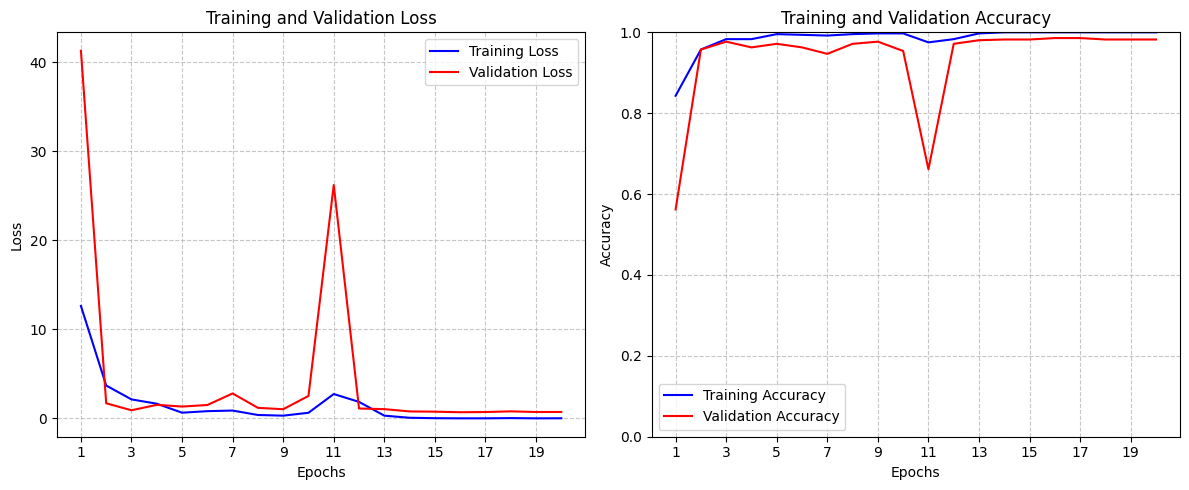


--- Fold 3 ---
Epoch 1/20, Train Loss: 12.7596, Train Acc: 0.8307, Val Loss: 17.2238, Val Acc: 0.7837
Epoch 2/20, Train Loss: 3.8739, Train Acc: 0.9557, Val Loss: 21.9964, Val Acc: 0.6720
Epoch 3/20, Train Loss: 1.8961, Train Acc: 0.9823, Val Loss: 1.4494, Val Acc: 0.9699
Epoch 4/20, Train Loss: 0.3886, Train Acc: 0.9956, Val Loss: 1.6630, Val Acc: 0.9628
Epoch 5/20, Train Loss: 1.8344, Train Acc: 0.9858, Val Loss: 1.2552, Val Acc: 0.9699
Epoch 6/20, Train Loss: 1.2256, Train Acc: 0.9894, Val Loss: 2.4793, Val Acc: 0.9486
Epoch 7/20, Train Loss: 0.1798, Train Acc: 1.0000, Val Loss: 0.5765, Val Acc: 0.9858
Epoch 8/20, Train Loss: 0.0557, Train Acc: 1.0000, Val Loss: 0.8508, Val Acc: 0.9840
Epoch 9/20, Train Loss: 0.1204, Train Acc: 0.9991, Val Loss: 0.9850, Val Acc: 0.9770
Epoch 10/20, Train Loss: 0.2437, Train Acc: 0.9973, Val Loss: 1.2888, Val Acc: 0.9734
Epoch 11/20, Train Loss: 0.4469, Train Acc: 0.9956, Val Loss: 2.7756, Val Acc: 0.9504
Epoch 12/20, Train Loss: 0.6885, Train Acc: 

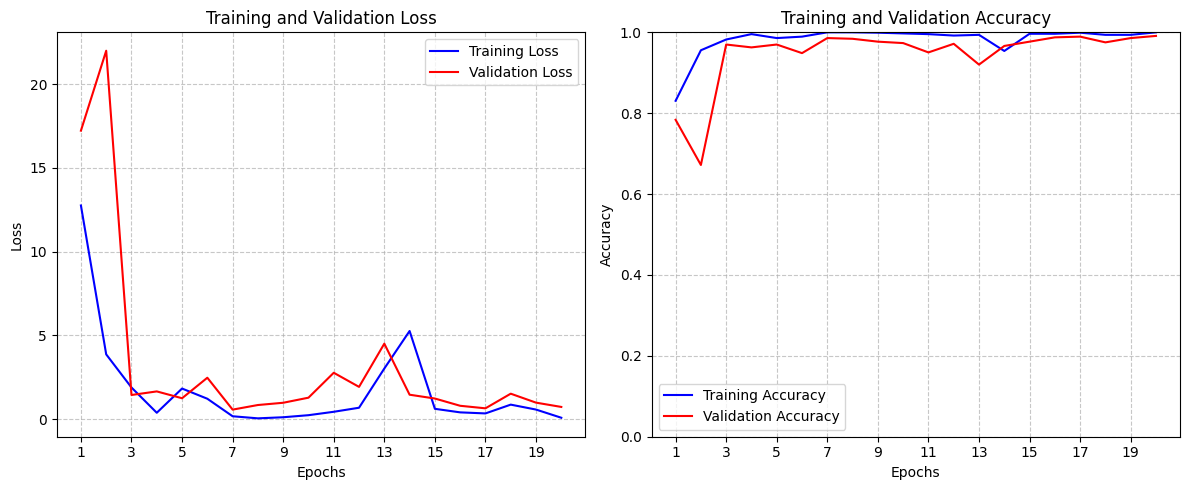


Average best validation accuracy across folds (rerun): 0.9894


In [22]:
# rerun training with the best hyperparameters
rerun_fold_results = []

for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n--- Fold {fold+1} ---")
    sc_train_dataset = Subset(single_channel_dataset, train_idx)
    sc_test_dataset = Subset(single_channel_dataset, test_idx)

    sc_train_loader = DataLoader(
        sc_train_dataset, 
        batch_size=32, 
        shuffle=True, 
        num_workers=4
    )

    sc_test_loader = DataLoader(
        sc_test_dataset, 
        batch_size=32, 
        shuffle=False,
        num_workers=4
    )

    # Initialize model, criterion, optimizer
    model = MultiChannelResnet(num_channels=1, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)


    # Train and get metrics
    train_losses, val_losses, train_accs, val_accs = train_model_with_visualization(
        model, criterion, optimizer, sc_train_loader, sc_test_loader
    )

    # Store results
    rerun_fold_results.append({
        'fold': fold+1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })

    # Plot metrics for this fold
    plot_metrics(train_losses, val_losses, train_accs, val_accs, epochs=20)

# Optionally, print summary statistics
avg_rerun_val_acc = sum([max(fr['val_accs']) for fr in rerun_fold_results]) / len(rerun_fold_results)
print(f"\nAverage best validation accuracy across folds (rerun): {avg_rerun_val_acc:.4f}")